# Tensor Completion

Reference tensor is generated from Gaussian Process (GP)

1. Build GP model of the reference tensor
2. Perform tensor completion using random init
3. Perform tensor completion using TT-cross reapproximation of GP model as init

In [1]:
from __future__ import print_function

import numpy as np

%matplotlib inline

from tqdm import tqdm

import pickle
import numpy as np
from matplotlib import interactive, pyplot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


import GPy

import fenics as fe
from hyperopt import fmin, tpe, hp
import tt
from tt.cross import rect_cross


import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=DataConversionWarning)


def generate_exact_gp_model(d, random_state=None, ARD=False):
    if random_state is None:
        random_state = np.random.RandomState()

    size = [5] * d
    train_size = min(np.prod(size), 5000)

    sigma = random_state.rand(d) * 0.5 + 0.1
    if ARD:
        kernel = GPy.kern.RBF(d, variance=1, lengthscale=sigma, ARD=True)
    else:
        kernel = GPy.kern.RBF(d, variance=1, lengthscale=sigma[0], ARD=False)
    
    grid_1d = [np.linspace(0, 1, k) for k in size]

    x_grid = np.meshgrid(*grid_1d)
    x_grid = np.hstack((x_grid[i].reshape(-1, 1) for i in range(d)))

    # take subsample if number of points in grid is too large
    x_train = x_grid
    if x_grid.shape[0] > train_size:
        p = np.random.permutation(x_grid.shape[0])
        x_train = x_grid[p[:train_size]]

    y_train = np.random.multivariate_normal(np.zeros(x_train.shape[0]),
                                            kernel.K(x_train, x_train),
                                            size=[1]).reshape(-1, 1)


    model_gp = GPy.models.GPRegression(x_train, y_train, kernel)
    model_gp.kern.lengthscale.fix()
    model_gp.optimize(messages=False)
    return model_gp

def tensor_element(model_gp, x, size=None):
    if size is not None:
        size = np.array(size)
    x = x / (size.reshape(1, -1) - 1)
    
    y = model_gp.predict(x)
    if len(y) == 2:
        return y[0]
    return y


def get_data(model_gp, n, size, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
        
    x = np.empty((n, len(size)), dtype=float)
    for i, s in enumerate(size):
        x[:, i] = random_state.randint(s, size=(n, ))

    y = tensor_element(model_gp, x, size)
    x = x / (np.array(size).reshape(1, -1) - 1)
    return x, y


def multiidx2idx(multiidx, size):
    idx = 0
    d = len(size)
    for i, s in enumerate(size[::-1]):
        idx += multiidx[d - i - 1] * s**i
    return idx


def idx2multiidx(idx, size):
    d = len(size)
    idx_copy = np.copy(idx)
    multiidx = np.empty((idx.shape[0], d), dtype=int)

    for i, s in enumerate(size[::-1]):
        multiidx[:, d - i - 1] = idx_copy % s
        idx_copy = (idx_copy - multiidx[:, d - i -1]) // s
        
    return multiidx


def calc_mse(y, x_tt, multiidx):
    error = 0
    for i, index in enumerate(multiidx):
        error += (y[i] - x_tt[index])**2

    error /= len(multiidx)
    return error[0]


def calc_ttcross_errors(model_gp, x):
    test_idx = random_state.randint(10**d, size=(10000))
    multiidx = idx2multiidx(test_idx, size)
    x_test = multiidx / (np.asarray(size) - 1)

    y_test, _ = model_gp.predict(x_test)
    mse = calc_mse(y_test, x, multiidx)
    return mse, np.sqrt(mse) / y_test.std()

### Define loss function

In [3]:
def build_graph(x_init, y_train, train_idx, y_test, test_idx):    
    estimated = t3f.get_variable('estimated', initializer=x_init)

    # Loss
    estimated_vals_train = t3f.gather_nd(estimated, train_idx)
    loss = tf.reduce_mean((estimated_vals_train - y_train) ** 2)
    
    estimated_vals_test = t3f.gather_nd(estimated, test_idx)    
    test_loss = tf.reduce_mean((estimated_vals_test - y_test)**2)
    return loss, test_loss, estimated

#### SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [4]:
def train(loss, test_loss, estimated_tensor, early_stopping_rounds=50):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    step = optimizer.minimize(loss)

    rounds_without_improvement = 0
    best_test_loss = np.inf
    best_loss_round = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_hist = []
        test_loss_hist = []

        for i in range(350):
            _, loss_v = sess.run([step, loss])
            loss_hist.append(loss_v)
            test_loss_hist.append(sess.run(test_loss))

            if best_test_loss > test_loss_hist[-1]:
                best_test_loss = test_loss_hist[-1]
                best_loss_round = i
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1
                
            if rounds_without_improvement >= early_stopping_rounds:
                break
        
        cores = sess.run(estimated_tensor.tt_cores)
        estimated_tensor_ttpy = tt.core.vector.tensor.from_list(cores)
        
#     pyplot.figure()
#     pyplot.plot(loss_hist, label='Train')
#     pyplot.plot(test_loss_hist, label='Test')
#     pyplot.legend()
#     pyplot.show()
        
    return loss_hist, test_loss_hist, estimated_tensor_ttpy

### Random init

In [5]:
def tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size, figure=None):
    tf.reset_default_graph()

    d = train_idx.shape[1]
    x_init = t3f.random_tensor(size, tt_rank=2)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, estimated_ttpy

### GP+TT-cross as init

In [10]:
def tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size):
    r = 2
    d = x_train.shape[1]

    kernel = GPy.kern.RBF(d)
    gp = GPy.models.GPRegression(x_train, y_train, kernel)
    gp.optimize()

    x0 = tt.rand(size, d, r)
    x_gp = rect_cross.cross(lambda x: gp.predict(x)[0], x0, nswp=2, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_gp_cores = tt.core.vector.tensor.to_list(x_gp)
    x_gp_cores = [core.astype(np.float32) for core in x_gp_cores]
    x_init = t3f.TensorTrain(x_gp_cores, size, x_gp.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, gp, x_gp

In [ ]:
d_list = range(3, 11)
r_list = [2] * len(d_list)
train_size_default = 500

n_runs = 10

random_state = np.random.RandomState(42)

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'init_mse_train': [], 'init_mse_test': []}


for i, d in enumerate(d_list):

    print('Dim: {}'.format(d))

    # generate problem and training and test sets
    model_gp = generate_exact_gp_model(d, random_state, ARD=False)
    size = [10 for i in range(d)]
    train_size = min(train_size_default, np.prod(size))
    
    test_idx = random_state.randint(10**d, size=(5000))
    test_idx = idx2multiidx(test_idx, size)
    x_test = test_idx / (np.asarray(size) - 1)
    y_test, _ = model_gp.predict(x_test)
    
    for run_counter in range(n_runs):
        print("Run #{}".format(run_counter))

        x_train, y_train = get_data(model_gp, train_size, size, random_state)
        train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size)

        
        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size)

        gp = results_gp[2]
        x_gp = results_gp[3]
        for i, mode in enumerate(['train', 'test']):
            errors_rand['mse_' + mode].append(results_rand[i])
            errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

            errors_gp['mse_' + mode].append(results_gp[i])
            errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

            if mode == 'train':
                gp_pr = gp.predict(x_train)[0]
                y_truth = y_train
                indices_truth = train_idx
            else:
                gp_pr = gp.predict(x_test)[0]
                y_truth = y_test
                indices_truth = test_idx

            errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
            errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
    for mode in ['train', 'test']:
        err_rand = errors_rand['mse_' + mode][-n_runs:]
        err_gp = errors_gp['mse_' + mode][-n_runs:]
        print('Rand: ', np.mean(err_rand), np.std(err_rand))
        print('GP:   ', np.mean(err_gp), np.std(err_gp))

for key in errors_rand:
    errors_rand[key] = np.array(errors_rand[key]).reshape(len(d_list), n_runs)
    
for key in errors_gp:
    errors_gp[key] = np.array(errors_gp[key]).reshape(len(d_list), n_runs)

In [15]:
import pickle
suffix = 'nruns={}'.format(n_runs)
with open('TensorCompletion_toy_problem_errors_rand_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_rand, f)

with open('TensorCompletion_toy_problem_errors_gpinit_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_gp, f)

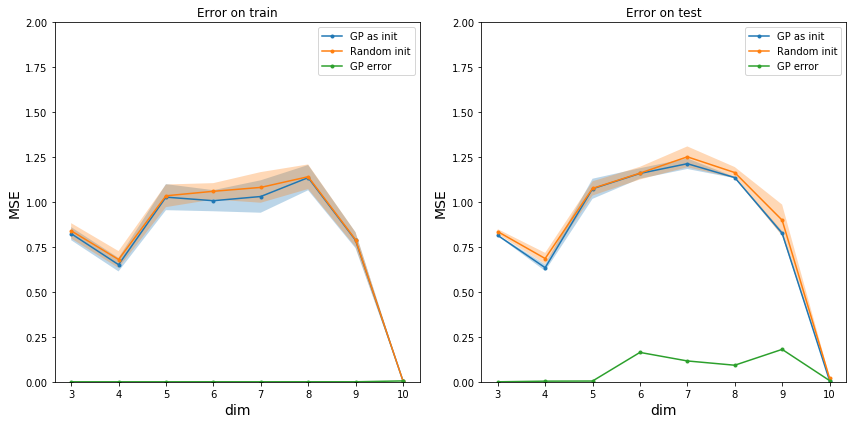

In [17]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'mse_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
    ax.plot(d_list, errors_gp['model_mse_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

### Larger train size

In [ ]:
d_list = range(4, 10)
r_list = [2] * len(d_list)
train_size_default = 5000

n_runs = 1

random_state = np.random.RandomState(42)

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'init_mse_train': [], 'init_mse_test': []}


for i, d in enumerate(d_list):

    print('Dim: {}'.format(d))

    # generate problem and training and test sets
    model_gp = generate_exact_gp_model(d, random_state, ARD=False)
    size = [10 for i in range(d)]
    train_size = min(train_size_default, np.prod(size))
    
    test_idx = random_state.randint(10**d, size=(5000))
    test_idx = idx2multiidx(test_idx, size)
    x_test = test_idx / (np.asarray(size) - 1)
    y_test, _ = model_gp.predict(x_test)
    
    for run_counter in range(n_runs):
        print("Run #{}".format(run_counter))

        x_train, y_train = get_data(model_gp, train_size, size, random_state)
        train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size)

        
        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size)

        gp = results_gp[2]
        x_gp = results_gp[3]
        for i, mode in enumerate(['train', 'test']):
            errors_rand['mse_' + mode].append(results_rand[i])
            errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

            errors_gp['mse_' + mode].append(results_gp[i])
            errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

            if mode == 'train':
                gp_pr = gp.predict(x_train)[0]
                y_truth = y_train
                indices_truth = train_idx
            else:
                gp_pr = gp.predict(x_test)[0]
                y_truth = y_test
                indices_truth = test_idx

            errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
            errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
    for mode in ['train', 'test']:
        err_rand = errors_rand['mse_' + mode][-n_runs:]
        err_gp = errors_gp['mse_' + mode][-n_runs:]
        print('Rand: ', np.mean(err_rand), np.std(err_rand))
        print('GP:   ', np.mean(err_gp), np.std(err_gp))

for key in errors_rand:
    errors_rand[key] = np.array(errors_rand[key]).reshape(len(d_list), n_runs)
    
for key in errors_gp:
    errors_gp[key] = np.array(errors_gp[key]).reshape(len(d_list), n_runs)

In [23]:
import pickle
suffix = 'nruns={}_train_size={}'.format(n_runs, train_size)
with open('TensorCompletion_toy_problem_errors_rand_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_rand, f)

with open('TensorCompletion_toy_problem_errors_gp_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_gp, f)

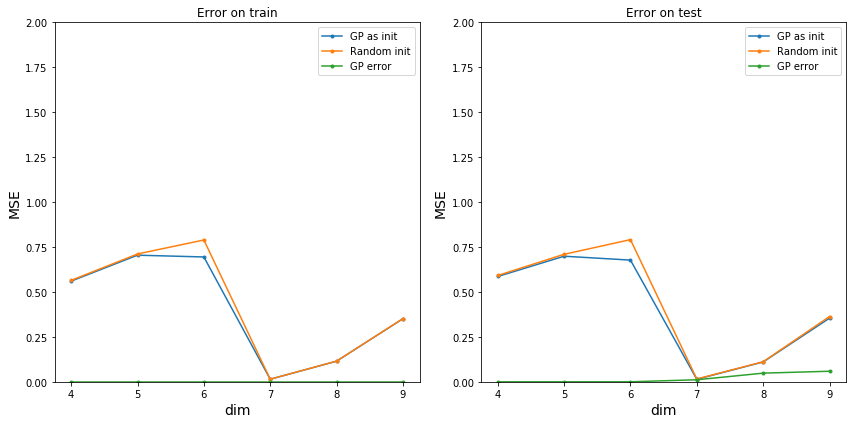

In [24]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'mse_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
    ax.plot(d_list, errors_gp['model_mse_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

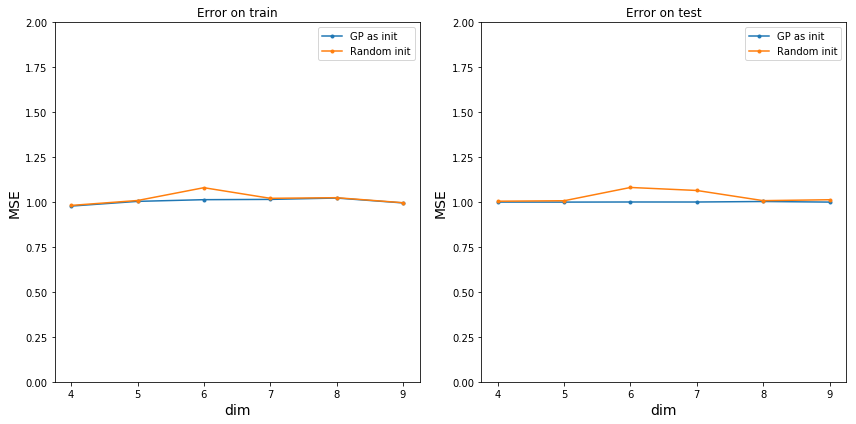

In [48]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'rel_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
#     ax.plot(d_list, errors_gp['model_rel_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

### Plot 2d slices

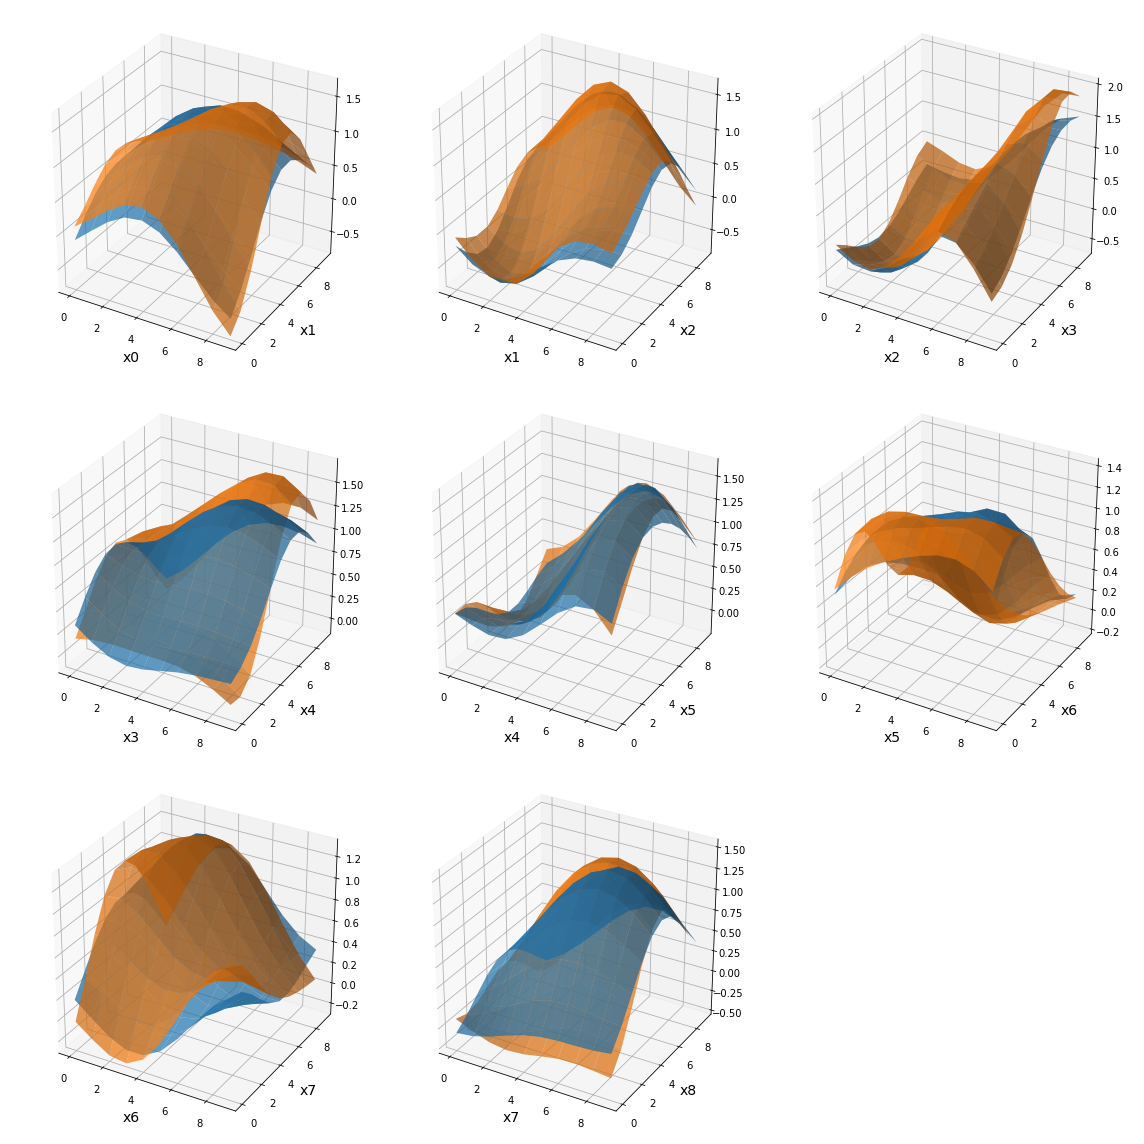

In [41]:
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

d = x_train.shape[1]
n = 10

value = np.random.randint(n, size=(1, d))

figure = pyplot.figure(figsize=(16, 16))
m = int(np.sqrt(d))

for i in range(d):
    for j in range(i + 1, min(i + 2, d)):
        idx = [i, j]

        plot_size = n
        dim = 2

        x0 = np.tile(value, (plot_size**dim, 1))
        XY = np.meshgrid(np.arange(n), np.arange(n))
        x_grid = np.hstack([XY[0].reshape(-1, 1), XY[1].reshape(-1, 1)])
        x0[:, idx] = x_grid
        
        y_exact, _ = model_gp.predict(x0 / (n - 1))
        y_pr, _ = gp.predict(x0 / (n - 1))

        ax = figure.add_subplot(m, m, i + 1, projection='3d')
        ax.plot_surface(XY[0], XY[1], y_pr.reshape(plot_size, plot_size), alpha=0.7)
        ax.plot_surface(XY[0], XY[1], y_exact.reshape(plot_size, plot_size), alpha=0.7)
        
        ax.set_xlabel('x{}'.format(i), fontsize=14)
        ax.set_ylabel('x{}'.format(j), fontsize=14)
figure.tight_layout()
pyplot.show()